# Breast Cancer Data Challenge

The problem that this data challenge tackles is the development of a model that is able to predict whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell. The breast cancer dataset was obtained from the University of Wisconsin Hospitals, Madison. Details of the dataset can be found and downloaded [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original)).   

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.utils.multiclass import unique_labels

## Load Data

In [2]:
df=pd.read_csv('breast-cancer-wisconsin.data',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
df.columns = ['ID','Thickness','Uniform_Size','Uniform_Shape','Adhesion','EpiCellSize','BareNuclei','Chromatin','Nucleoli','Mitoses','Class'] # assign column names
df['Class'] = df['Class'].map({2:0,4:1}) # benign = 0, malignant = 1
df.head()

,ID,Thickness,Uniform_Size,Uniform_Shape,Adhesion,EpiCellSize,BareNuclei,Chromatin,Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


## EDA

In [4]:
df.isnull().sum() # check number of null

ID               0
Thickness        0
Uniform_Size     0
Uniform_Shape    0
Adhesion         0
EpiCellSize      0
BareNuclei       0
Chromatin        0
Nucleoli         0
Mitoses          0
Class            0
dtype: int64

In [5]:
df.describe()

,ID,Thickness,Uniform_Size,Uniform_Shape,Adhesion,EpiCellSize,Chromatin,Nucleoli,Mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,0.344778
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.475636
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
ID               699 non-null int64
Thickness        699 non-null int64
Uniform_Size     699 non-null int64
Uniform_Shape    699 non-null int64
Adhesion         699 non-null int64
EpiCellSize      699 non-null int64
BareNuclei       699 non-null object
Chromatin        699 non-null int64
Nucleoli         699 non-null int64
Mitoses          699 non-null int64
Class            699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [7]:
df=df.drop(labels='ID',axis=1) # remove ID column

In [8]:
df = df[df['BareNuclei'] !='?'] ##exclude rows with ?
df.info()
df['BareNuclei'] = df['BareNuclei'].astype(int) ## BareNuclei can be converted 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 10 columns):
Thickness        683 non-null int64
Uniform_Size     683 non-null int64
Uniform_Shape    683 non-null int64
Adhesion         683 non-null int64
EpiCellSize      683 non-null int64
BareNuclei       683 non-null object
Chromatin        683 non-null int64
Nucleoli         683 non-null int64
Mitoses          683 non-null int64
Class            683 non-null int64
dtypes: int64(9), object(1)
memory usage: 58.7+ KB


## EDA Plotting

Text(0, 0.5, 'Number of Occurrences')

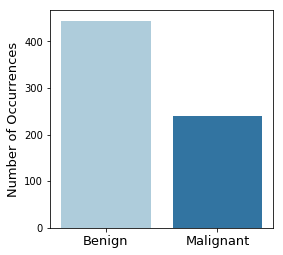

In [9]:
# Plot histograms for the two classes
fig = plt.figure(figsize=(4, 4));
ax = sns.countplot(x='Class',data=df, palette="Paired");
ax.set_xticklabels(['Benign','Malignant'], fontsize=13)
ax.set_xlabel('')
ax.set_ylabel('Number of Occurrences', fontsize=13)

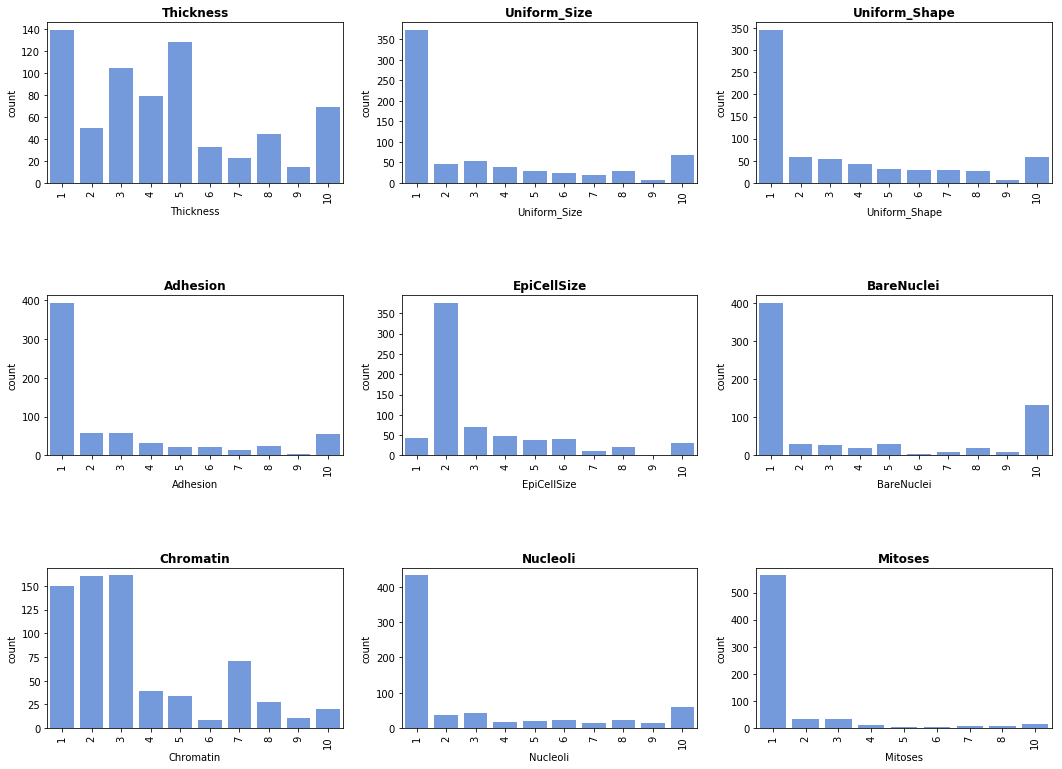

In [10]:
# Plot histograms for all features
fig = plt.figure(figsize=(18, 18))
cols = 3
rows = np.ceil(float(df.shape[1]) / cols)
for i, column in enumerate(df.columns[:-1]):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column, weight='bold')
    sns.countplot(x=column,data=df, color='cornflowerblue')
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

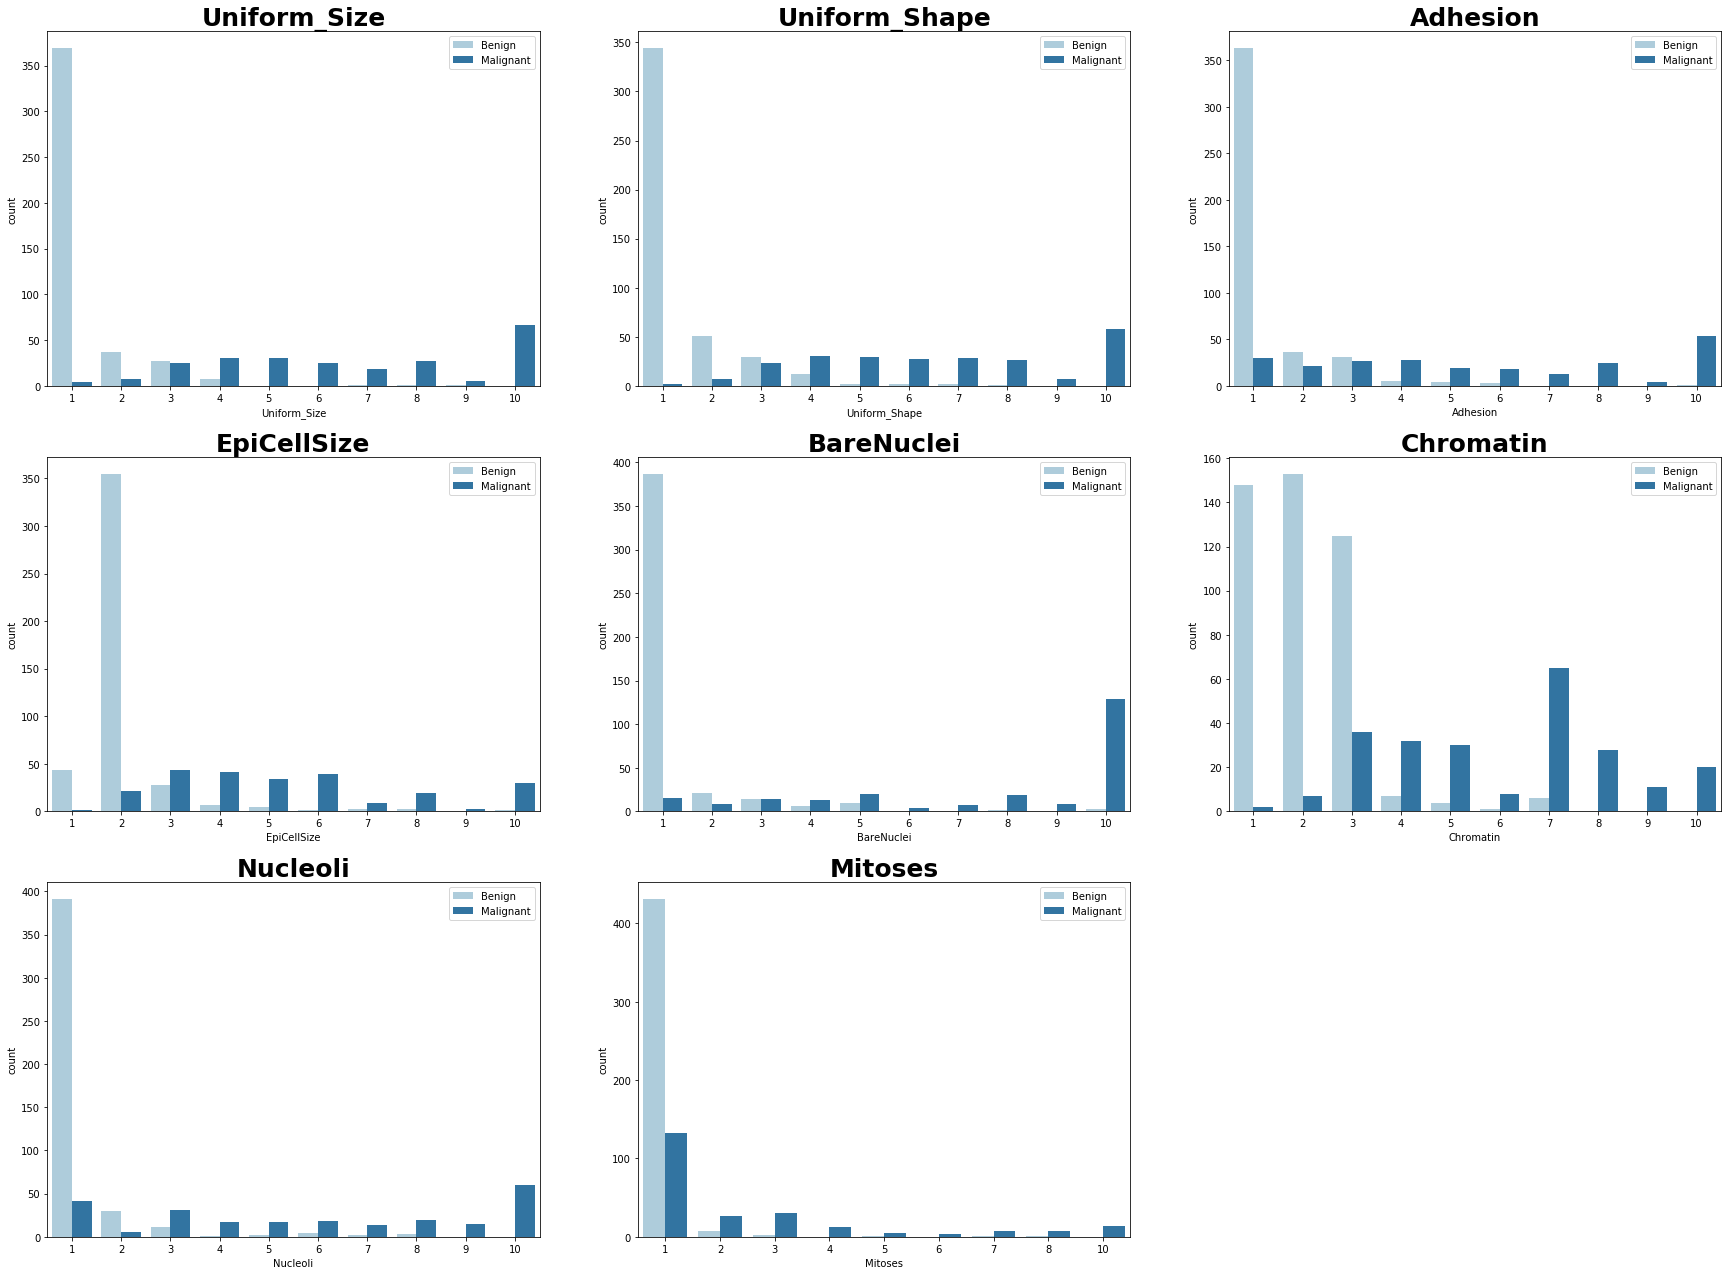

In [11]:
fig = plt.figure(figsize=(30, 30))
cols = 3
rows = np.ceil(float(df.shape[1]) / cols)

for i,column in enumerate(df.columns[1:len(df.columns)-1]):
    ax=fig.add_subplot(rows, cols, i+1)
    ax.set_title(column, fontsize=25, weight='bold')
    sns.countplot(x=column, hue='Class', palette="Paired", data=df)
    plt.legend(labels=['Benign', 'Malignant'], loc = 1)



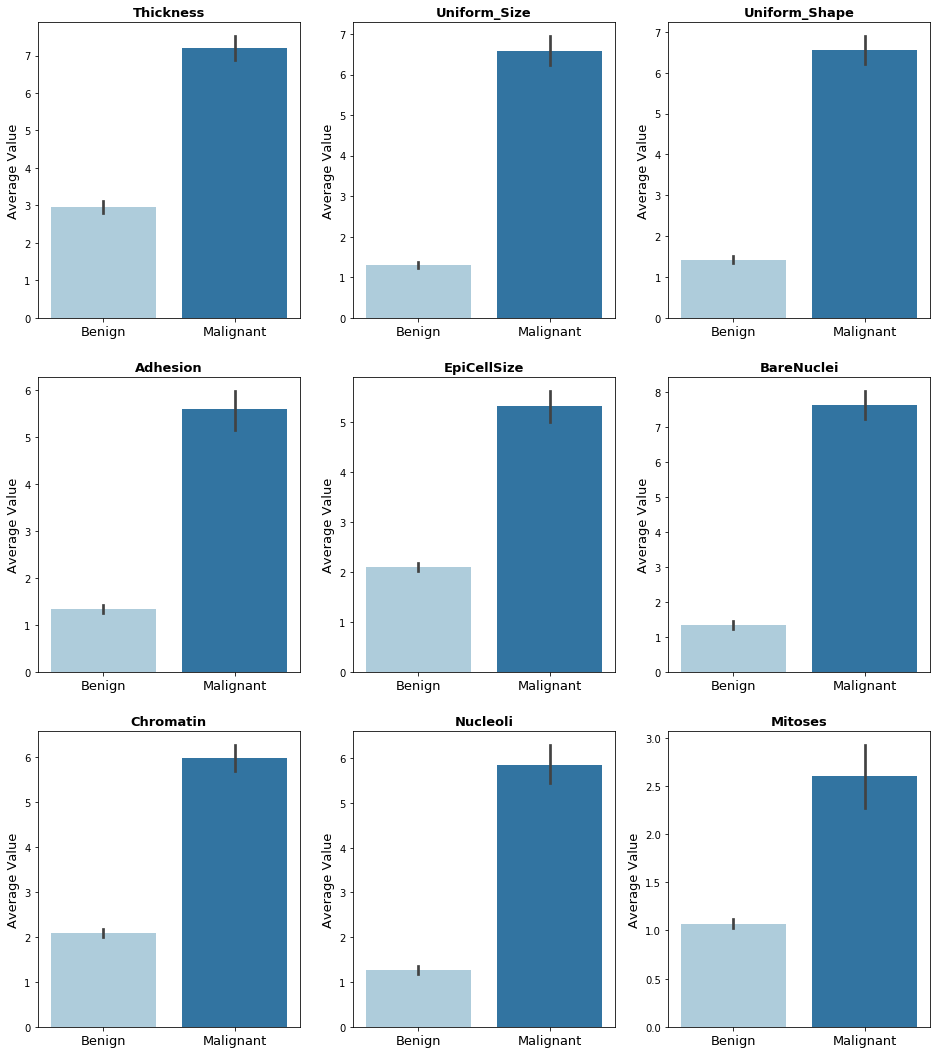

In [12]:
fig = plt.figure(figsize=(16, 25))
cols = 3
rows = np.ceil(float(df.shape[1]) / cols)

for i,column in enumerate(df.columns[0:len(df.columns)-1]):
    ax=fig.add_subplot(rows, cols, i+1)
    sns.barplot(x='Class', y=column,data=df, palette="Paired").set_title(column)
    ax.set_xticklabels(['Benign','Malignant'], fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel('Average Value', fontsize=13)
    ax.set_title(column, fontsize = 13, weight='bold')

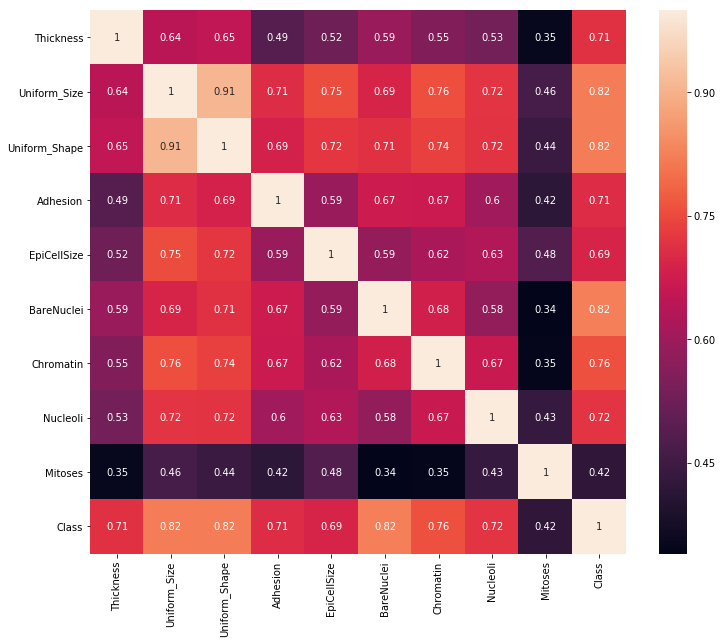

In [13]:
corr = df.corr()
fig=plt.figure(figsize=(12,10))
sns.heatmap(corr,annot = True);

## Implement Model

In [14]:
from sklearn.model_selection import train_test_split

X = df
X = X.drop('Class',axis=1)
Y = df['Class']

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=17)
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

/Users/tung-linwu/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/tung-linwu/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
/Users/tung-linwu/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


In [15]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100) # Grid-Search and Cross-validation
forest.fit(x_train,y_train)

forest_params = {'max_depth': [2, 5, 10], 
                  'min_samples_leaf': [5,10,15,20,30],
                  'max_features': [2,4,6,8,9]}

best_forest = GridSearchCV(forest,forest_params, cv=5)
best_forest.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 5, 10], 'min_samples_leaf': [5, 10, 15, 20, 30], 'max_features': [2, 4, 6, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## Evaluation of Model

In [16]:
##Random forest accuracy
forest_pred=best_forest.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, forest_pred))

Accuracy: 0.9707317073170731


In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

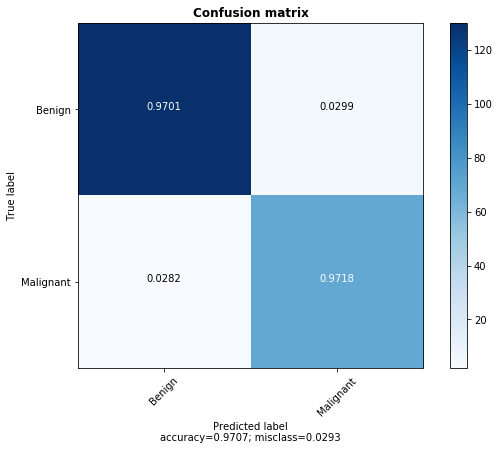

In [18]:
Forest_Confusion = confusion_matrix(y_test, forest_pred)
plot_confusion_matrix(Forest_Confusion, target_names=['Benign','Malignant'])

## Feature Importance

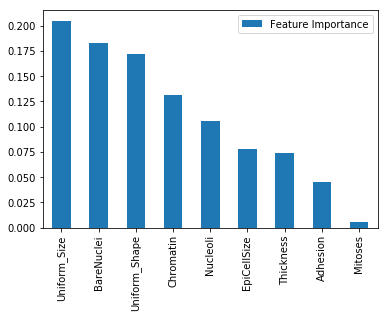

In [19]:
feature_importances = pd.DataFrame(best_forest.best_estimator_.feature_importances_, index = X.columns, columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)    
feature_importances.plot.bar()

## ROC and PR Curves

In [20]:
fprforest, tprforest, thresholdforest = metrics.roc_curve(y_test, forest_pred)
fprforest2, tprforest2, thresholdforest2 = roc_curve(y_test, forest_pred)
forest_roc_auc = metrics.auc(fprforest, tprforest)
forest_probs = best_forest.predict_proba(x_test)

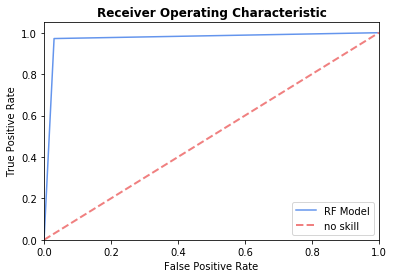

In [21]:
plt.figure()
plt.plot(fprforest2, tprforest2, color='cornflowerblue')
plt.plot([0, 1], [0, 1], color='lightcoral', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', weight='bold')
plt.legend(labels = ['RF Model', 'no skill'], loc="lower right")
plt.show()

In [22]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, forest_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.93


In [23]:
forest_probs2 = forest_probs[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, forest_probs2)
f1 = f1_score(y_test, forest_pred) # calculate F1 score
auc_disp = auc(recall, precision) # calculate precision-recall AUC
ap = average_precision_score(y_test, forest_probs2) # calculate average precision score
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_disp, ap))

f1=0.958 auc=0.991 ap=0.991


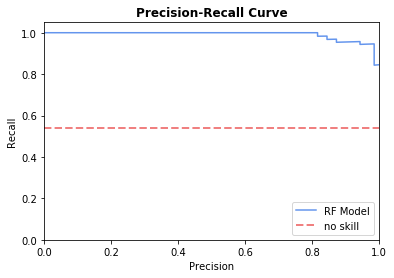

In [24]:
plt.figure()
plt.plot(recall, precision, color='cornflowerblue')
neg = df['Class'][df['Class'] == 0].count() # plot no skill
pos = df['Class'][df['Class'] == 1].count()
plt.plot([0, 1], [pos / neg, pos / neg], color='lightcoral', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve', weight='bold')
plt.legend(labels = ['RF Model', 'no skill'], loc="lower right")
plt.show()